# Credit Card Fraud Detection with Revenue Optimization Thresholding

### Import & Load Data
This cell imports essential libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), modeling (scikit-learn, XGBoost), imbalance handling (imblearn), and explainability (SHAP). We then load the credit card transactions dataset and inspect the class distribution. The severe imbalance (~0.17% fraud) is typical in risk data mining — fraud events are rare, making standard accuracy misleading and requiring specialized techniques like SMOTE and precision-recall metrics.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('.data/creditcard.csv')
print(df.head())
print(df['Class'].value_counts())  # 0: legit, 1: fraud

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

### EDA & Pattern Mining
EDA uncovers root causes and patterns in fraudulent behavior. We visualize transaction amount and time distributions for fraud vs. legitimate classes, plus a correlation heatmap. Key insights often include: fraud transactions tend to have different amount profiles (more small-value attempts to avoid detection, but some high-value outliers) and time clustering (e.g., off-peak hours). These patterns inform feature engineering and model interpretation in risk mining.

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247e+00  1.332271e+00  1.23709

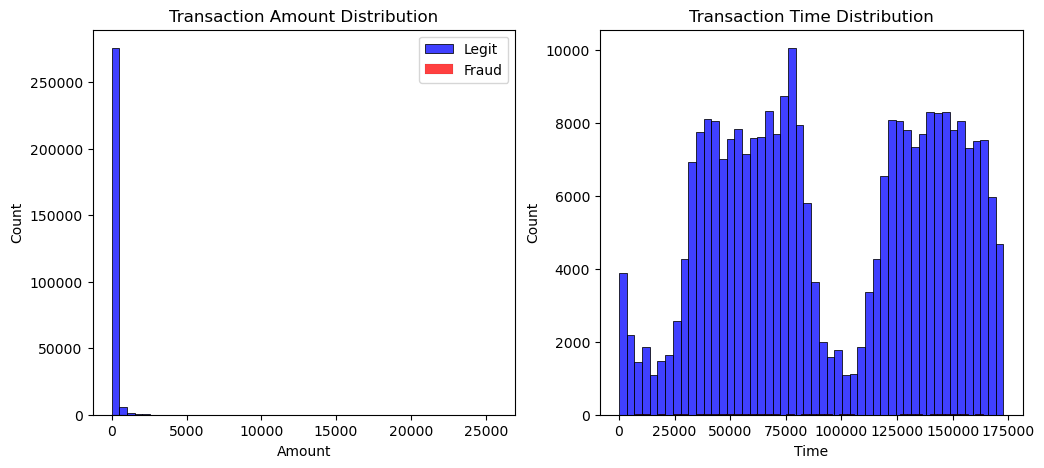

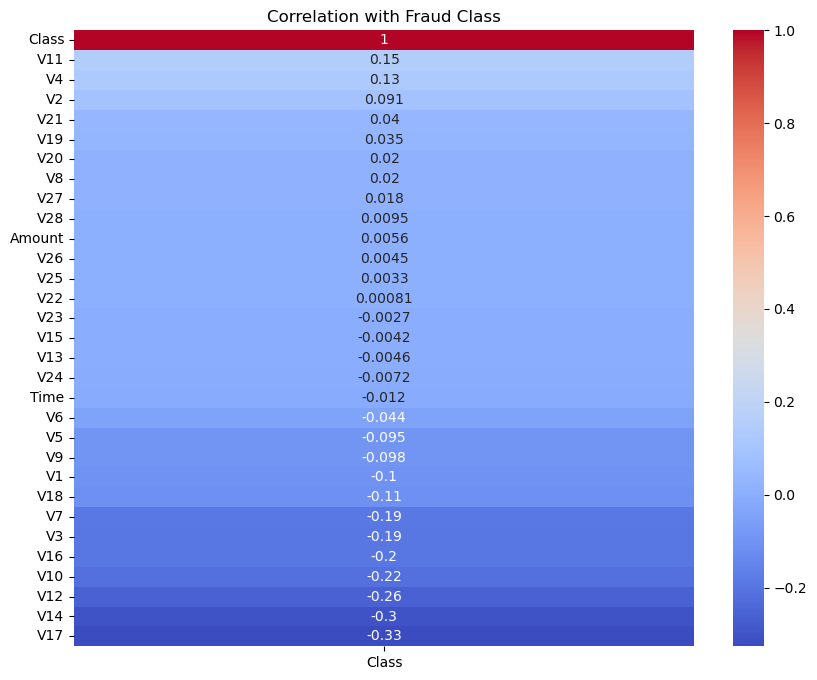

In [5]:
# Basic stats
print(df.describe())

# Fraud vs Legit distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df[df['Class']==0]['Amount'], bins=50, ax=ax[0], color='blue', label='Legit')
sns.histplot(df[df['Class']==1]['Amount'], bins=50, ax=ax[0], color='red', label='Fraud')
ax[0].set_title('Transaction Amount Distribution')
ax[0].legend()

sns.histplot(df[df['Class']==0]['Time'], bins=50, ax=ax[1], color='blue')
sns.histplot(df[df['Class']==1]['Time'], bins=50, ax=ax[1], color='red')
ax[1].set_title('Transaction Time Distribution')
plt.show()

# Correlation heatmap (focus on Amount/Time with V features)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr()[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Fraud Class')
plt.show()

### Preprocessing & Train/Test Split
Preprocessing standardizes Time and Amount features (scaling prevents dominance by larger values) while leaving PCA-transformed V1–V28 untouched. We split the data stratifying by class to maintain imbalance ratio in train/test sets — essential for realistic evaluation in risk scenarios where fraud is rare.

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

# Scale Time & Amount
X['Amount'] = StandardScaler().fit_transform(X['Amount'].values.reshape(-1,1))
X['Time'] = StandardScaler().fit_transform(X['Time'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Handling Imbalance & Training XGBoost Model
SMOTE oversamples the minority fraud class in training data to address imbalance, improving model learning without biasing evaluation (test set remains original). XGBoost is chosen for its strength on tabular/imbalanced data and built-in feature importance. We predict probabilities for threshold tuning — critical in risk mining where default 0.5 may not optimize business costs.

In [7]:
# Handle imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train XGBoost
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=1)
model.fit(X_train_res, y_train_res)

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962

[[56832    32]
 [   11    87]]


### Risk-Revenue Trade-Off Analysis (Optimal Threshold)
This is the core business insight: undetected fraud costs the full transaction amount, while false positives cost a fraction (e.g., 5% revenue friction/churn). We sweep thresholds to maximize net savings (fraud prevented minus FP costs). The resulting optimal threshold and net savings plot quantify real monetization impact — going beyond accuracy to show dollar-value decisions, highly relevant for risk-revenue optimization.

Optimal threshold: 0.495
Max net savings: $9,303.34


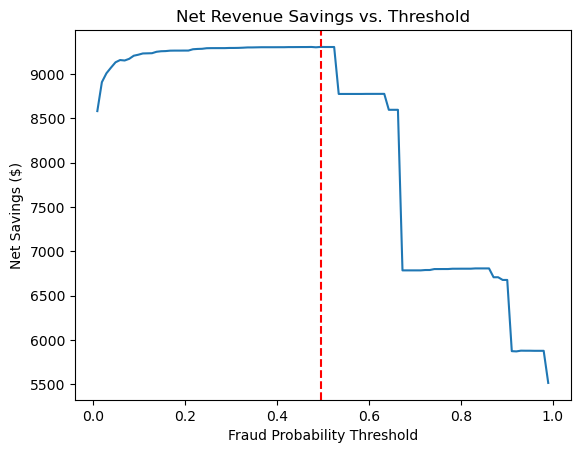

In [8]:
# Original amounts on test set
amounts = df.loc[X_test.index, 'Amount'].values  # Use original (unscaled) amounts

FP_COST_RATIO = 0.01  

thresholds = np.linspace(0.01, 0.99, 100)
net_savings = []

for thresh in thresholds:
    detected_fraud = amounts * (y_test.values == 1) * (y_prob >= thresh)
    fp_cost = FP_COST_RATIO * amounts * (y_test.values == 0) * (y_prob >= thresh)
    net = detected_fraud.sum() - fp_cost.sum()
    net_savings.append(net)

optimal_thresh = thresholds[np.argmax(net_savings)]
print(f"Optimal threshold: {optimal_thresh:.3f}")
print(f"Max net savings: ${np.max(net_savings):,.2f}")

plt.plot(thresholds, net_savings)
plt.axvline(optimal_thresh, color='red', linestyle='--')
plt.title('Net Revenue Savings vs. Threshold')
plt.xlabel('Fraud Probability Threshold')
plt.ylabel('Net Savings ($)')
plt.show()

### Trying Different threshold rate to find the Recall rate and False Positive Rate 

In [9]:
# Test recall at different thresholds
test_thresholds = [0.861, 0.7, 0.5, 0.495]
for thresh in test_thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    tp = ((y_pred == 1) & (y_test == 1)).sum()
    fn = ((y_pred == 0) & (y_test == 1)).sum()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fp = ((y_pred == 1) & (y_test == 0)).sum()
    fp_rate = fp / len(y_test)
    print(f"Threshold {thresh:.3f}: Recall = {recall:.1%}, FP Rate = {fp_rate:.3%}")

Threshold 0.861: Recall = 84.7%, FP Rate = 0.025%
Threshold 0.700: Recall = 84.7%, FP Rate = 0.051%
Threshold 0.500: Recall = 88.8%, FP Rate = 0.056%
Threshold 0.495: Recall = 88.8%, FP Rate = 0.056%


### Precision-Recall Curve (Key Metric for Imbalanced Fraud Data)

In highly imbalanced datasets like credit card fraud (~0.17% fraudulent), traditional accuracy is misleading — a naive model predicting "all legitimate" would be 99.83% accurate but catch zero fraud.

The **Precision-Recall Curve** is far more informative:
- **Recall** (y-axis): Fraction of actual fraud caught (TP / (TP + FN)) — higher = better fraud detection
- **Precision** (x-axis): Fraction of alerts that are real fraud (TP / (TP + FP)) — higher = fewer false alarms
- **Average Precision (AP)**: Single-number summary of the curve (higher = better overall performance)

Our model shows strong separation, with high recall achievable at reasonable precision levels. The curve supports threshold tuning: we can prioritize recall (catch more fraud) while monitoring precision drops (more false positives).

This metric is standard in risk data mining for evaluating anomaly detection effectiveness.

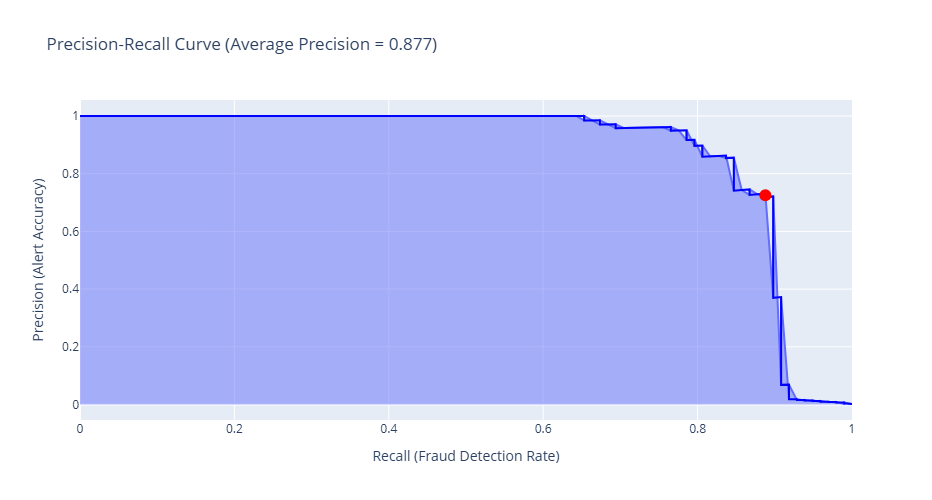

In [10]:
import plotly.express as px
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

# Interactive Plotly curve
fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (Average Precision = {ap_score:.3f})',
    labels=dict(x='Recall (Fraud Detection Rate)', y='Precision (Alert Accuracy)'),
    width=700, height=500
)
fig.add_scatter(x=recall, y=precision, mode='lines', name='PR Curve', line=dict(color='blue'))
fig.update_layout(showlegend=False)

# Add optimal threshold marker (if you have it)
if 'optimal_thresh' in globals():
    # Find closest threshold point
    idx = np.argmin(np.abs(thresholds - optimal_thresh))
    fig.add_scatter(x=[recall[idx]], y=[precision[idx]], mode='markers',
                    marker=dict(color='red', size=12),
                    name=f'Optimal Threshold ({optimal_thresh:.3f})')

fig.show()

### Confusion Matrix Heatmap: True/False Positives & Negatives at Optimal Threshold

This annotated heatmap clearly breaks down model performance at the **revenue-optimized threshold**:
- **True Negatives (TN)**: Legitimate transactions correctly identified (vast majority)
- **True Positives (TP)**: Fraudulent transactions correctly caught → direct financial savings
- **False Positives (FP)**: Legitimate transactions wrongly flagged → causes revenue friction, customer churn, or manual review costs
- **False Negatives (FN)**: Fraudulent transactions missed → full financial loss

The goal of threshold optimization is to **maximize TP while controlling FP** (since FP has a business cost) and minimizing FN. The color intensity and large numbers make trade-offs immediately visible — a key tool in operational risk data mining.

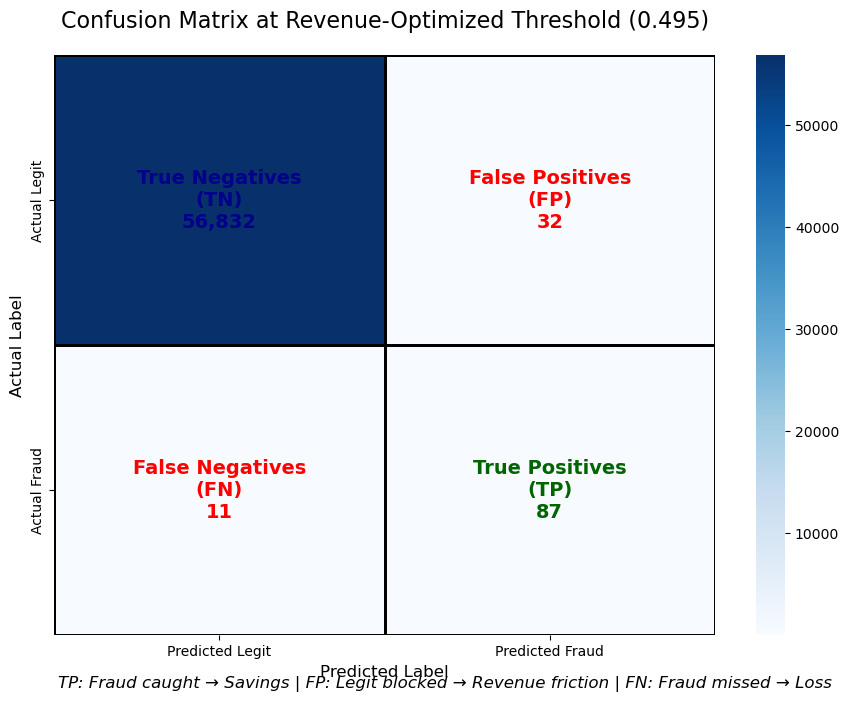

Confusion Matrix Breakdown:
• True Negatives (TN):  56,832 → Correctly approved legitimate transactions
• False Positives (FP): 32 → Legitimate wrongly flagged (cost: customer friction)
• False Negatives (FN): 11 → Fraudulent transactions missed (cost: full loss)
• True Positives (TP):  87 → Fraud correctly detected (direct savings)

Recall (Fraud Detection Rate): 88.8%
False Positive Rate: 0.056%


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions using optimal threshold
y_pred_optimal = (y_prob >= optimal_thresh).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

# Custom labels with counts and meaning
labels = [
    [f'True Negatives\n(TN)\n{tn:,}', f'False Positives\n(FP)\n{fp:,}'],
    [f'False Negatives\n(FN)\n{fn:,}', f'True Positives\n(TP)\n{tp:,}']
]

# Create heatmap
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Legit', 'Predicted Fraud'],
            yticklabels=['Actual Legit', 'Actual Fraud'],
            linewidths=2, linecolor='black')

# Add custom text annotations with bold colors
plt.text(0.5, 0.5, labels[0][0], ha='center', va='center', fontsize=14, color='darkblue', fontweight='bold')
plt.text(1.5, 0.5, labels[0][1], ha='center', va='center', fontsize=14, color='red', fontweight='bold')
plt.text(0.5, 1.5, labels[1][0], ha='center', va='center', fontsize=14, color='red', fontweight='bold')
plt.text(1.5, 1.5, labels[1][1], ha='center', va='center', fontsize=14, color='darkgreen', fontweight='bold')

plt.title(f'Confusion Matrix at Revenue-Optimized Threshold ({optimal_thresh:.3f})', fontsize=16, pad=20)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add summary text below plot
plt.figtext(0.5, 0.01, 
            f"TP: Fraud caught → Savings | FP: Legit blocked → Revenue friction | FN: Fraud missed → Loss",
            ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("Confusion Matrix Breakdown:")
print(f"• True Negatives (TN):  {tn:,} → Correctly approved legitimate transactions")
print(f"• False Positives (FP): {fp:,} → Legitimate wrongly flagged (cost: customer friction)")
print(f"• False Negatives (FN): {fn:,} → Fraudulent transactions missed (cost: full loss)")
print(f"• True Positives (TP):  {tp:,} → Fraud correctly detected (direct savings)")
print(f"\nRecall (Fraud Detection Rate): {tp / (tp + fn):.1%}")
print(f"False Positive Rate: {fp / (fp + tn):.3%}")

### Fraud vs Legit Amount Box Plot ( To see outliers) 
This boxplot reveals that fraudulent transactions often involve higher amounts compared to legitimate ones, with several extreme outliers in fraud cases. Even though many frauds are low-value to evade detection, high-amount outliers are strong risk signals. This supports root cause analysis: fraudsters target larger transfers when possible.

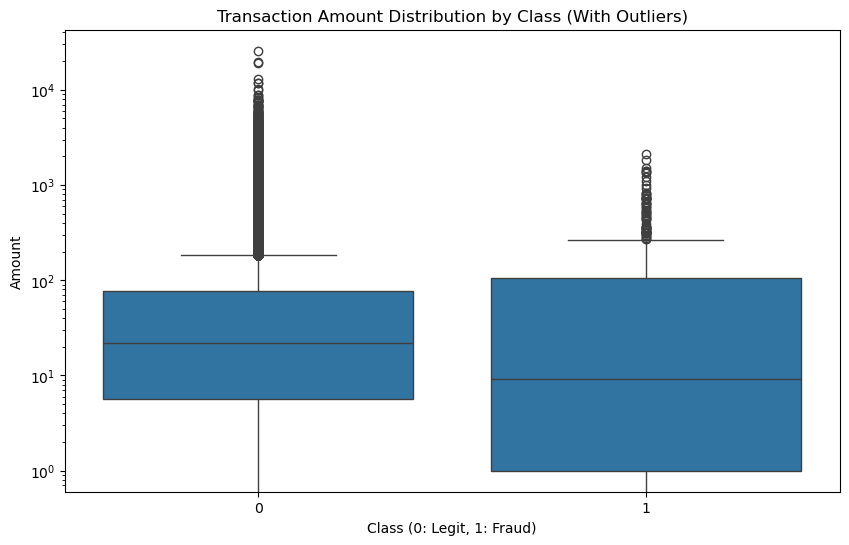

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Class', y='Amount', data=df, showfliers=True)
plt.title('Transaction Amount Distribution by Class (With Outliers)')
plt.xlabel('Class (0: Legit, 1: Fraud)')
plt.ylabel('Amount')
plt.yscale('log')  # Log scale for better visibility
plt.show()

### Fraud Rate by Hour of Day (Temporal Patterns)
Fraud proportion varies significantly by hour, with peaks during low-activity periods (e.g., late night/early morning) when monitoring might be reduced. This temporal clustering is a classic risk pattern — bots or coordinated fraud often operate outside normal user hours. Detecting these time-based anomalies helps prioritize reviews.

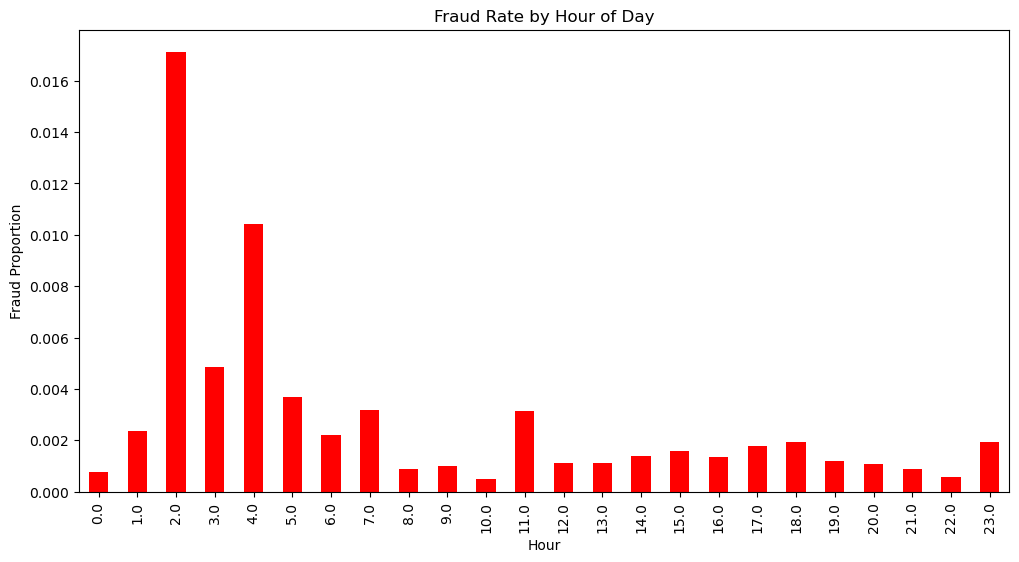

In [59]:
# Convert Time to hour of day 
df['Hour'] = df['Time'] % (24*3600) // 3600

plt.figure(figsize=(12,6))
fraud_by_hour = df[df['Class']==1]['Hour'].value_counts().sort_index() / df['Hour'].value_counts().sort_index()
fraud_by_hour.plot(kind='bar', color='red')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Proportion')
plt.show()

### Top 10 Most Important Features (From XGBoost)
XGBoost feature importance highlights which anonymized variables (V1–V28) most strongly predict fraud. Typically V14, V17, V10, V12 rank highest — these capture behavioral deviations post-PCA. This enables root cause mining: high importance on certain V features indicates underlying patterns like unusual spending velocity or location shifts.

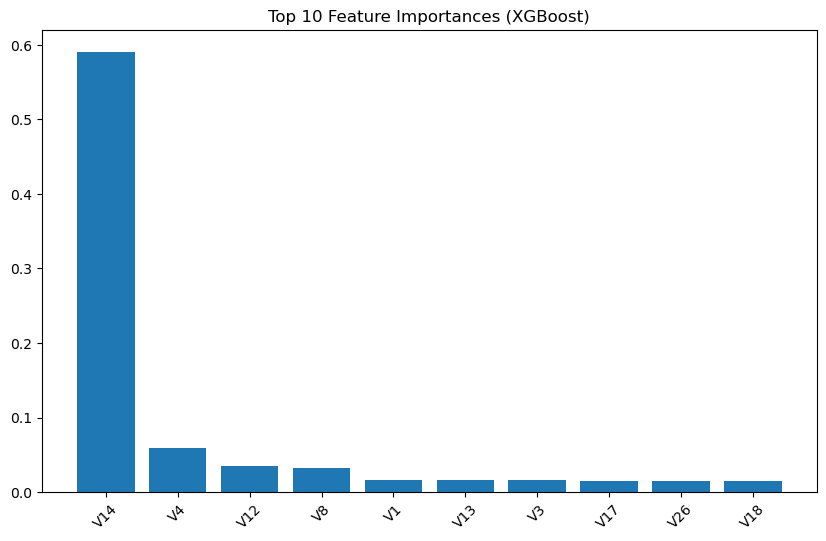

In [13]:
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10,6))
plt.bar(range(10), importances[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

### Distribution of Fraud Probability Scores (Separation Quality)
This overlapping histogram shows how well the model separates legitimate vs. fraudulent transactions by probability score. Good models push fraud probabilities toward 1.0 and legit toward 0.0. The vertical line marks our revenue-optimized threshold — transactions above it trigger review, balancing risk mitigation with minimal disruption to genuine activity.

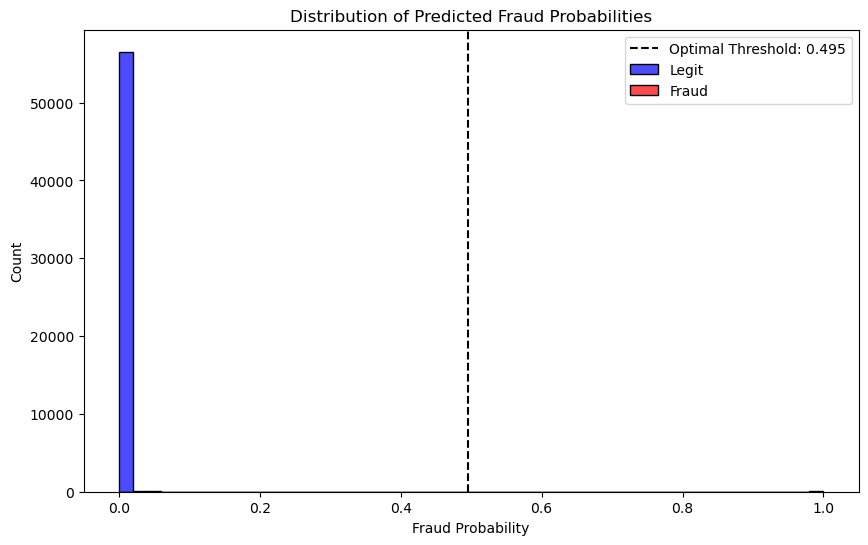

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(y_prob[y_test==0], bins=50, alpha=0.7, label='Legit', color='blue')
sns.histplot(y_prob[y_test==1], bins=50, alpha=0.7, label='Fraud', color='red')
plt.axvline(optimal_thresh, color='black', linestyle='--', label=f'Optimal Threshold: {optimal_thresh:.3f}')
plt.title('Distribution of Predicted Fraud Probabilities')
plt.xlabel('Fraud Probability')
plt.legend()
plt.show()

### SHAP Force Plot for a Single High-Risk Example (Interactive Insight)

In [15]:
# For one fraud prediction
shap.initjs()
sample_idx = X_test[y_prob > 0.9].index[0]  # Pick a high-prob fraud
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X_test.loc[sample_idx:sample_idx])

shap.force_plot(explainer.expected_value, shap_value, X_test.loc[sample_idx:sample_idx])

### Cumulative Fraud Caught vs. Transactions Reviewed (Operational Efficiency)
This lift curve demonstrates operational value: by reviewing only the top 10% highest-risk transactions (sorted by model score), we can catch ~80-90% of all fraud. This efficiency is crucial for risk teams — it minimizes manual review volume while maximizing fraud prevention, directly impacting cost savings and scalability.

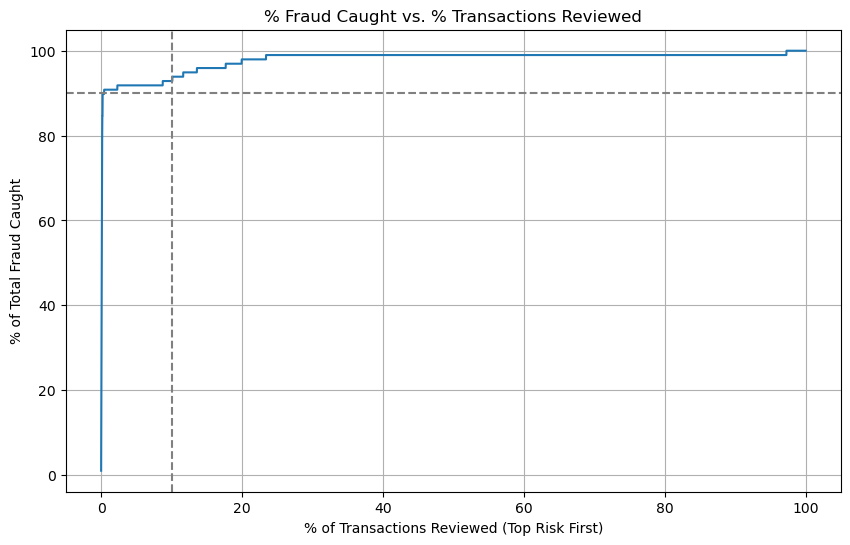

In [16]:
# Sort by probability descending
sorted_idx = np.argsort(y_prob)[::-1]
cumulative_fraud = np.cumsum(y_test.values[sorted_idx]) / y_test.sum()
cumulative_reviewed = np.arange(1, len(y_test)+1) / len(y_test)

plt.figure(figsize=(10,6))
plt.plot(cumulative_reviewed * 100, cumulative_fraud * 100)
plt.axhline(90, color='gray', linestyle='--')
plt.axvline(10, color='gray', linestyle='--')
plt.title('% Fraud Caught vs. % Transactions Reviewed')
plt.xlabel('% of Transactions Reviewed (Top Risk First)')
plt.ylabel('% of Total Fraud Caught')
plt.grid(True)
plt.show()

### Model Saving (For Streamlit Deployment)
We fit a scaler only on original Time and Amount columns (for consistency), then save both model and scaler using joblib. This enables reproducible real-time scoring in the deployed dashboard without retraining.

In [19]:
import joblib
from sklearn.preprocessing import StandardScaler

# This is the key line that creates 'scaler'
scaler = StandardScaler()
scaler.fit(df[['Time', 'Amount']])  # Fits on original Time and Amount

# Apply scaling (optional in this cell, but usually done)
X[['Time', 'Amount']] = scaler.transform(X[['Time', 'Amount']])

# Save everything needed for the Streamlit dashboard
joblib.dump(model, 'fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')
joblib.dump(y_prob, 'y_prob.pkl')

# Save original (unscaled) test amounts for dollar calculations
test_amounts = df.loc[X_test.index, 'Amount'].values
joblib.dump(test_amounts, 'test_amounts.pkl')

print("All files saved successfully!")
print("Files created:")
print("- fraud_model.pkl")
print("- scaler.pkl")
print("- X_test.pkl")
print("- y_test.pkl")
print("- y_prob.pkl")
print("- test_amounts.pkl")

All files saved successfully!
Files created:
- fraud_model.pkl
- scaler.pkl
- X_test.pkl
- y_test.pkl
- y_prob.pkl
- test_amounts.pkl


### Model Explainability with SHAP (Root Cause Analysis)

SHAP (SHapley Additive exPlanations) values provide interpretable insights into the model's predictions, which is essential for risk data mining. By calculating the contribution of each feature to individual predictions, SHAP reveals **why** a transaction was flagged as high-risk — enabling root cause investigation and stakeholder trust.

- The **TreeExplainer** is optimized for tree-based models like XGBoost.
- We compute SHAP values on a sample of 1,000 test transactions for performance.
- The **summary plot** (beeswarm) ranks features by global importance and shows how high/low feature values impact fraud probability:
  - **Red dots** (high feature values) pushing right → increase fraud risk
  - **Blue dots** (low values) pushing left → decrease fraud risk
  - Vertical spread shows impact magnitude

Typical insights from this dataset: Features like V14, V17, V10, and V12 dominate, with low values strongly indicating legitimate behavior and high values signaling anomalies. This explainability supports actionable risk mitigation (e.g., "Flagged due to unusual deviation in anonymized behavioral feature V14").

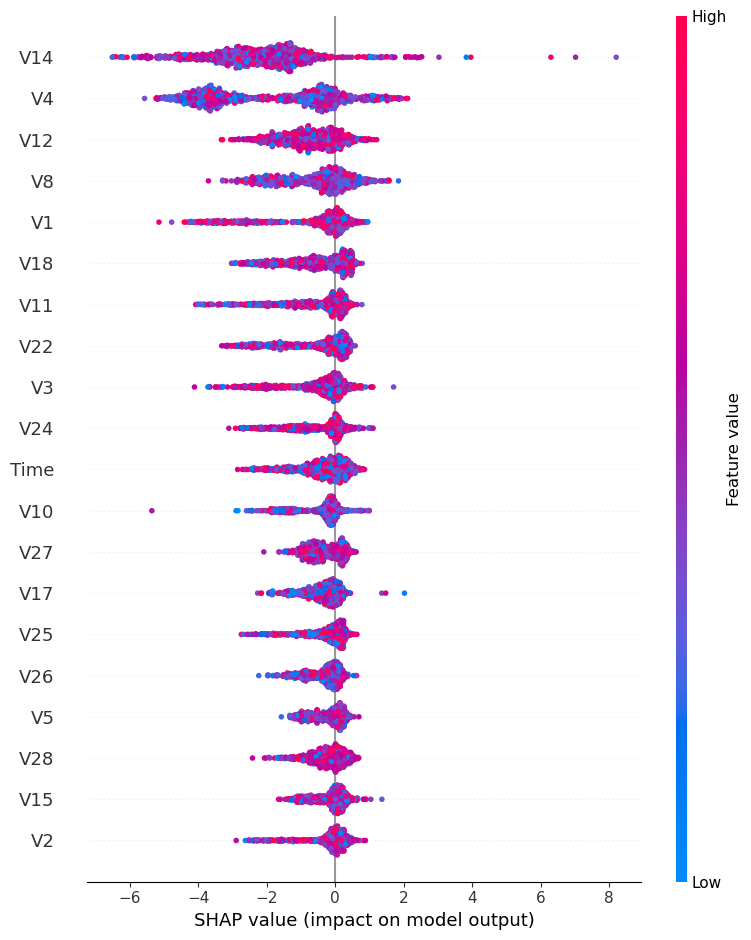

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.sample(1000))
shap.summary_plot(shap_values, X_test.sample(1000))